<h1 align=center> Optimisation d'un K-nn regresseur pour prédire la qualité de vin rouge  </h1>

<h2 align=center>CentraleSupélec-OpenClassrooms Certifiyng Training</h2>

<h3 align=center>Jean Martial Tagro </h3>

On prend le jeu de données sur le vinho verde rouge qui contient des informations physico-chimiques de vins rouge portugais, ainsi que leur qualité telle que notée par des humains.

L'étude consiste à évaluer le modèle pour optimiser l'algorithme K-nn via différents critères de performance (MSE, R-squared) et choisir les meilleurs hyper-paramètres (le nombre de voisins), à l’aide d’une grid search.

In [2]:
import pandas as pd
%pylab inline

from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


### 1. Obtention et traitement du dataset

In [3]:
data = pd.read_csv('winequality-red.csv', sep=";")

In [4]:
print(data.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [5]:
data.head()
#print(data.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
# Extraction en 2 arrays numpy les points et étiquettes
X = data[data.columns[:-1]].values
y = data['quality'].values

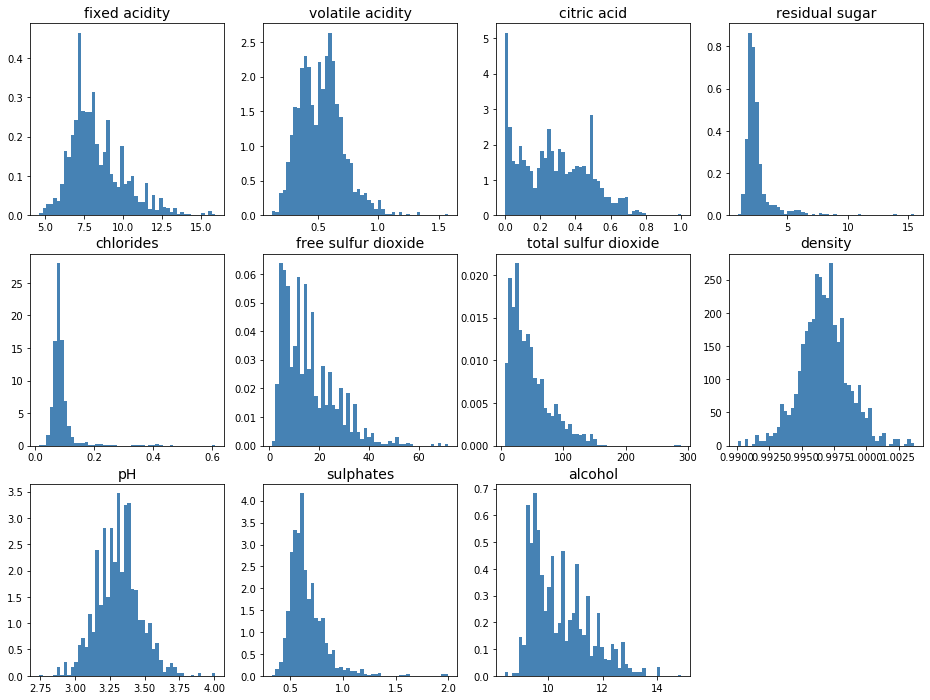

In [12]:
# Observation des features

fig = plt.figure(figsize=(16,12))

for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

On remarque que les features occupent des plages de données ne sont pas uniformément distribuées. On va donc standardiser, pour éviter par exemple que la feature 'total sulfur dioxyde' n'écrase pas les autres.

#### Séparons nos données en un jeu de test et un jeu d'entraînement :

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

#### Standardisons les données

In [15]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

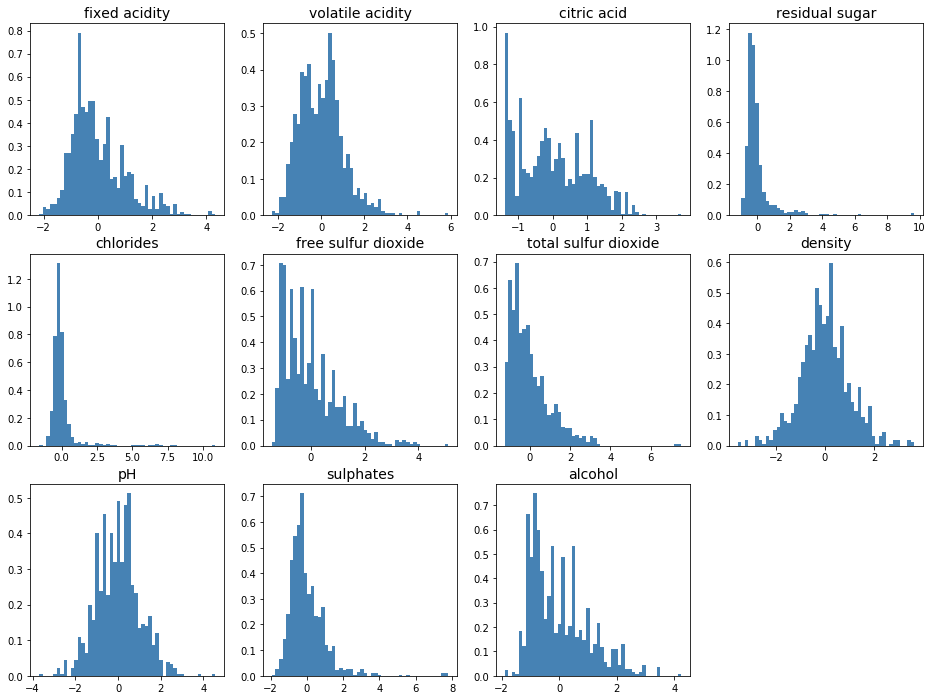

In [16]:
# On check la standardisation

fig = plt.figure(figsize=(16,12))

for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

---

### 2. Pré-évaluation par approches naïves

#### 2.1. Approche naïve sur la moyenne des scores (qualité)

Comparons maintenant notre modèle à un modèle aléatoire qui retourne systématiquement la valeur moyenne des étiquettes du jeu de données d'entraînement.

In [29]:
from sklearn import dummy
dum = dummy.DummyRegressor(strategy='mean') # on prend la moyenne des valeurs du jeu d'entrainement

# on fitte (entraine)
dum.fit(X_train_std, y_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_std)

# Evaluation
print("Le RMSE du modèle naïf retournant systématiquement la moyenne des valeurs du jeu d'entrainement est : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)) ))

Le RMSE du modèle naïf retournant systématiquement la moyenne des valeurs du jeu d'entrainement est : 0.80


#### 2.2. Approche naïve sur la prédiction aléatoire de scores (qualité)

Comparons-le maintenant à une deuxième approche naïve, qui consiste à prédire des valeurs aléatoires, distribuées uniformément entre les valeurs basse et haute des étiquettes du jeu de données d'entraînement.

In [30]:
# on genère les valeurs aléatoires entre les valeurs de la target min et max du jeu 
# d'entrainement à la taille du jeu de test
y_pred_random = np.random.randint(np.min(y), np.max(y), y_test.shape)

# Evaluation
print("Le RMSE du modèle naïf retournant systématiquement la moyenne des valeurs du jeu d'entrainement est : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_random))))

Le RMSE du modèle naïf retournant systématiquement la moyenne des valeurs du jeu d'entrainement est : 1.67


On peut déjà voir que, sur ce dataset, <strong>le modèle retournant systématiquement la moyenne est meilleur que le modèle aléatoire</strong> car ayant une RMSE inférieure.
<br>

---

### 3. Implémentation de gridSearch_MSE

<p>Dans la suite, on va implémenter un algorithme K-nn dont on va chercher à optimiser l'hyper-paramètre K via une Grid search, gridSearch_MSE en comparant les MSE (Mean Squared Error) qui devront être normalement inférieur à celui de la baseline retournant la valeur moyenne, i.e RSE 0.80</p>

L'objectif ici est l'implémemtation d'une Grid Search pour une Cross validation qui compare les performances de différents K-nn en termes de MSE, R-squared. Cette fonction devra retourner le meilleur modèle (hyper-paramètre) qui minimise le MSE ou le RMSE ici.

In [56]:
# implementation de la fonction gridSearch_MSE

def gridSearch_MSE(hyperparams, cv):
    
    """
    Cette fonction execute une validation croisée sur différents k-NN
    entrées : cv nombre de folds, hyperparams liste des hyperparamètres k-NN à tester
    sorties : Les performances des modèles testées : RMSE, R-Squared 
    """
    
    k_optimal = 0
    means_rmse = [] # pour stocker les RMSE moyens en vue de la selection du meilleur K
    means_rsquared = [] # pour stocker les R-squared moyens
    
    # Creation des folds stratifiés
    skf = StratifiedKFold(n_splits=cv, random_state=None) 
    
    # pour chaque hyperparams, on fait la validation croisée
    for index, valeur_k in enumerate(hyperparams):
        
        rmse = []
        r_squared = []
        
        # construction du k-nn regresseur correspondant
        knn = neighbors.KNeighborsRegressor(valeur_k)      
        
        # pour chaque fold
        for train, test in skf.split(X_train_std, y_train): # Attention : train, test sont des index
            
            knn.fit(X_train_std[train], y_train[train])
            predict = knn.predict(X_train_std[test])

            # on calcule le RMSE et le R-quared et on les mets dans les listes correspondantes
            rmse.append(np.sqrt(metrics.mean_squared_error(y_train[test], predict)))            
            r_squared.append(metrics.r2_score(y_train[test], predict))
        
        rmse_knn = np.mean(rmse) #RMSE moyen des folds pour l'hyper-parametre
        r_squared_knn = np.mean(r_squared) #R-Squared moyen des folds pour l'hyper-parametre
        
        means_rmse.append(rmse_knn)
        means_rsquared.append(r_squared_knn)
        
        print("(RMSE = {:.2f} / R-Squared = {:.2f} ) for neighbors = {}".format( rmse_knn, r_squared_knn, valeur_k))
        
        # le meilleur K minimise le RMSE
        if (rmse_knn == min(means_rmse)):
            k_optimal = valeur_k
        
    print("Le meilleur hyperparamètre sur le jeu d'entrainement selon gridSearch_MSE est K = ", k_optimal)
    print("Le {}-NN a le RMSE minimal qui est RMSE = {:.2f}".format(k_optimal, min(means_rmse)))

---

In [64]:
# Appel de gridSearch_MSE sur 5 folds et K dans [3, 5, ...25]
gridSearch_MSE([3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22, 25], 5)

(RMSE = 0.71 / R-Squared = 0.22 ) for neighbors = 3
(RMSE = 0.69 / R-Squared = 0.27 ) for neighbors = 5
(RMSE = 0.68 / R-Squared = 0.29 ) for neighbors = 7
(RMSE = 0.67 / R-Squared = 0.31 ) for neighbors = 9
(RMSE = 0.67 / R-Squared = 0.31 ) for neighbors = 11
(RMSE = 0.67 / R-Squared = 0.32 ) for neighbors = 13
(RMSE = 0.67 / R-Squared = 0.31 ) for neighbors = 15
(RMSE = 0.67 / R-Squared = 0.31 ) for neighbors = 17
(RMSE = 0.68 / R-Squared = 0.30 ) for neighbors = 19
(RMSE = 0.68 / R-Squared = 0.30 ) for neighbors = 21
(RMSE = 0.68 / R-Squared = 0.30 ) for neighbors = 22
(RMSE = 0.68 / R-Squared = 0.30 ) for neighbors = 25
Le meilleur hyperparamètre sur le jeu d'entrainement selon gridSearch_MSE est K =  13
Le 13-NN a le RMSE minimal qui est RMSE = 0.67


Notre fonction grid search a trouvé le K-nn qui minimise l'erreur quadratique moyenne, en l'occurence le 13-NN dont RMSE=0.67. Cependant, cette performance est un peu biaisée car correspond à celle sur le jeu d'entrainement global de la validation croisée.
Pour obtenir la performance définitive, on fait l'évalue sur le jeu de test extérieur global à la validation croisée.

---

### 4. Performance finale globale du 13-NN sur le jeu de test extérieur

In [65]:
knn = neighbors.KNeighborsRegressor(13)

#on fitte sur l'ensemble du jeu d'entrainement global cette fois
knn.fit(X_train_std, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                    weights='uniform')

In [66]:
predictions = knn.predict(X_test_std)

print("Le 13-NN a une RMSE finale de {}".format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))

Le 13-NN a une RMSE finale de 0.6509362094076107


<h3><font color='steelblue'>Meilleure Performance que celles des approches naïves !</font></h3>

---

In [59]:
#On pourrait utiliser la grid search originale

#clf = model_selection.GridSearchCV(
#    neighbors.KNeighborsClassifier(), # un classifieur kNN
#    param_grid,     # hyperparamètres à tester
#    cv=5,           # nombre de folds de validation croisée
#    scoring='RSE'   # score à optimiser
#)

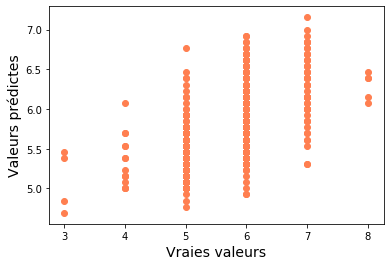

In [67]:
# Representation
plt.scatter(y_test, predictions, color='coral')
plt.xlabel('Vraies valeurs', fontsize=14)
plt.ylabel('Valeurs prédictes', fontsize=14)
plt.show()